Using device: mps
Epoch  10 | Train loss: 0.082409 | Val MSE: 0.018551
Epoch  20 | Train loss: 0.080377 | Val MSE: 0.016362
Epoch  30 | Train loss: 0.078944 | Val MSE: 0.014898
Epoch  40 | Train loss: 0.077645 | Val MSE: 0.014728
Epoch  50 | Train loss: 0.077519 | Val MSE: 0.012502
Epoch  60 | Train loss: 0.077089 | Val MSE: 0.013504
Epoch  70 | Train loss: 0.075871 | Val MSE: 0.012066
Epoch  80 | Train loss: 0.076072 | Val MSE: 0.012233


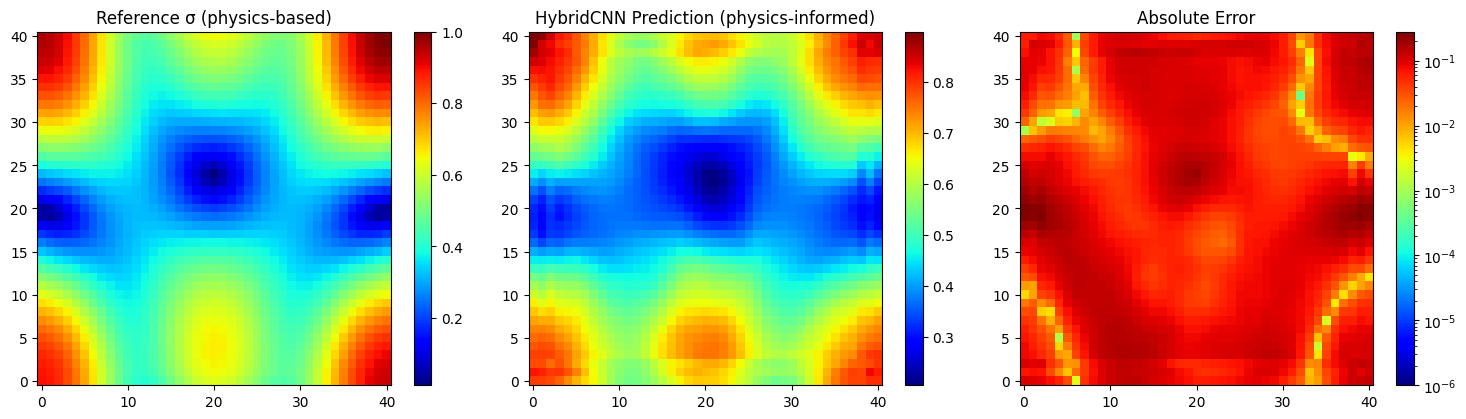

In [6]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
from jax.scipy.linalg import lu_factor, lu_solve
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Device configuration: Prefer MPS (Apple Silicon GPU) if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# --------------------------------------------------
# 1. Krylov-Uzawa Solver (Physics-based "exact" reference) - unchanged
# --------------------------------------------------
A = jnp.array([
    [ 4.0, -1.0, 0.0, 0.0],
    [-1.0, 4.0, -1.0, 0.0],
    [ 0.0, -1.0, 4.0, -1.0],
    [ 0.0, 0.0, -1.0, 3.0]
])
B = jnp.array([
    [1.0, -1.0, 0.0, 0.0],
    [0.0, 1.0, -1.0, 0.0]
])
lu_A, piv_A = lu_factor(A)
def A_solve(rhs):
    return lu_solve((lu_A, piv_A), rhs)

@jit
def krylov_uzawa(B, f, g, max_iter=5000, tol=1e-12):
    u = A_solve(f)
    p = jnp.zeros(B.shape[0])
    r = g - B @ u
    d = r
    rr_old = jnp.dot(r, r)
    def cond_fun(state):
        k, _, _, _, _, rr = state
        return (k < max_iter) & (rr > tol**2)
    def body_fun(state):
        k, u, p, r, d, rr_old = state
        z = A_solve(B.T @ d)
        Bz = B @ z
        denom = jnp.dot(d, Bz)
        alpha = rr_old / jnp.where(denom == 0.0, jnp.inf, denom)
        p_new = p + alpha * d
        u_new = u - alpha * z
        r_new = r - alpha * Bz
        rr_new = jnp.dot(r_new, r_new)
        beta = rr_new / jnp.where(rr_old == 0.0, 1.0, rr_old)
        d_new = r_new + beta * d
        return k + 1, u_new, p_new, r_new, d_new, rr_new
    init_state = (0, u, p, r, d, rr_old)
    _, u_final, p_final, _, _, _ = lax.while_loop(cond_fun, body_fun, init_state)
    return u_final, p_final

# --------------------------------------------------
# 2. Generate synthetic dataset - unchanged
# --------------------------------------------------
def generate_dataset(num_samples=1000, grid_size=41):
    nx = ny = grid_size - 1
    x = jnp.linspace(0, 1, grid_size)
    y = jnp.linspace(0, 1, grid_size)
    X, Y = jnp.meshgrid(x, y)
    def single_sample(key):
        key1, key2 = jax.random.split(key)
        coeffs = jax.random.normal(key1, (6,))
        ux = (coeffs[0] * jnp.sin(jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[1] * jnp.cos(2*jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[2] * X * (1 - X))
        uy = (coeffs[3] * jnp.cos(jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[4] * jnp.sin(2*jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[5] * Y * (1 - Y))
        eps_xx = jnp.gradient(ux, x, axis=1)
        eps_yy = jnp.gradient(uy, y, axis=0)
        eps_xy = 0.5 * (jnp.gradient(ux, y, axis=0) + jnp.gradient(uy, x, axis=1))
        sigma_vm = jnp.sqrt(eps_xx**2 + eps_yy**2 - eps_xx*eps_yy + 3*eps_xy**2)
        sigma_vm = sigma_vm / (jnp.max(sigma_vm) + 1e-8)
        return jnp.stack([ux, uy], axis=0), sigma_vm
    keys = jax.random.split(jax.random.PRNGKey(42), num_samples)
    inputs, targets = vmap(single_sample)(keys)
    return inputs, targets

# --------------------------------------------------
# 3. PyTorch CNN model - unchanged
# --------------------------------------------------
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

# --------------------------------------------------
# 4. Physics-informed loss - unchanged
# --------------------------------------------------
def physics_informed_loss(pred, target, ux_uy, lambda_phys=1.0):
    mse = nn.functional.mse_loss(pred, target)
    ux = ux_uy[:, 0, :, :]
    uy = ux_uy[:, 1, :, :]
    def central_grad(f):
        f_pad = nn.functional.pad(f.unsqueeze(1), (1, 1, 1, 1), mode='reflect').squeeze(1)
        grad_x = (f_pad[:, 1:-1, 2:] - f_pad[:, 1:-1, :-2]) / 2.0
        grad_y = (f_pad[:, 2:, 1:-1] - f_pad[:, :-2, 1:-1]) / 2.0
        return grad_x, grad_y
    eps_xx_x, eps_xx_y = central_grad(ux)
    eps_yy_x, eps_yy_y = central_grad(uy)
    div_u = eps_xx_x + eps_yy_y
    incompress_residual = torch.mean(div_u**2)
    sigma_xx = pred
    sigma_yy = pred
    sigma_xy = 0.1 * pred
    sigma_xx_dx, _ = central_grad(sigma_xx)
    _, sigma_xy_dy = central_grad(sigma_xy)
    res_x = sigma_xx_dx + sigma_xy_dy
    sigma_xy_dx, _ = central_grad(sigma_xy)
    _, sigma_yy_dy = central_grad(sigma_yy)
    res_y = sigma_xy_dx + sigma_yy_dy
    phys_residual = torch.mean(res_x**2 + res_y**2)
    total_phys = phys_residual + 0.5 * incompress_residual
    return mse + lambda_phys * total_phys

# --------------------------------------------------
# 5. Custom Dataset - moved to top level
# --------------------------------------------------
class PhysicsDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# --------------------------------------------------
# 6. Training function - key fixes applied
# --------------------------------------------------
def train_with_physics_integration():
    inputs_jax, targets_jax = generate_dataset(num_samples=2000, grid_size=41)
    inputs = torch.tensor(np.array(inputs_jax), device=device, dtype=torch.float32)
    targets = torch.tensor(np.array(targets_jax), device=device, dtype=torch.float32)

    train_ds = PhysicsDataset(inputs[:1800], targets[:1800])
    val_ds = PhysicsDataset(inputs[1800:], targets[1800:])

    # Critical fix: set num_workers=0 on macOS (especially with MPS) to avoid multiprocessing pickling errors
    # Also conditionally disable pin_memory when not beneficial
    num_workers = 0  # Safe default; change to 2-4 only if running on Linux/Windows with CUDA
    pin_memory = (device.type != 'cpu')

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=32,
                            num_workers=num_workers, pin_memory=pin_memory)

    model = HybridCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    epochs = 80
    lambda_phys = 10.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for ux_uy_batch, target_batch in train_loader:
            ux_uy_batch = ux_uy_batch.to(device)  # Already on device if pin_memory used, but safe
            target_batch = target_batch.to(device)
            optimizer.zero_grad()
            pred = model(ux_uy_batch)
            loss = physics_informed_loss(pred, target_batch, ux_uy_batch, lambda_phys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ux_uy_batch, target_batch in val_loader:
                ux_uy_batch = ux_uy_batch.to(device)
                target_batch = target_batch.to(device)
                pred = model(ux_uy_batch)
                loss = nn.functional.mse_loss(pred, target_batch)
                val_loss += loss.item()

        scheduler.step(val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | Train loss: {train_loss/len(train_loader):.6f} "
                  f"| Val MSE: {val_loss/len(val_loader):.6f}")

    return model, inputs, targets

# --------------------------------------------------
# 7. Run training and visualize (FIXED)
# --------------------------------------------------

model, inputs, targets = train_with_physics_integration()

# Select a valid test sample
test_idx = -1
ux_uy_test = inputs[test_idx].unsqueeze(0)   # FIX
target_test = targets[test_idx]

model.eval()
with torch.no_grad():
    pred_test = model(ux_uy_test.to(device))[0].cpu().numpy()

true_test = target_test.cpu().numpy()
error = np.abs(pred_test - true_test)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(true_test, origin="lower", cmap="jet")
axs[0].set_title("Reference σ (physics-based)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_test, origin="lower", cmap="jet")
axs[1].set_title("HybridCNN Prediction (physics-informed)")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(
    error,
    origin="lower",
    cmap="jet",
    norm=LogNorm(vmin=1e-6, vmax=max(error.max(), 1e-6))
)
axs[2].set_title("Absolute Error")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

Epoch  10 | Train loss: 0.241506 | Val MSE: 0.019073
Epoch  20 | Train loss: 0.239521 | Val MSE: 0.017217
Epoch  30 | Train loss: 0.239130 | Val MSE: 0.016716
Epoch  40 | Train loss: 0.236361 | Val MSE: 0.013561
Epoch  50 | Train loss: 0.235154 | Val MSE: 0.013191
Epoch  60 | Train loss: 0.234780 | Val MSE: 0.012563
Epoch  70 | Train loss: 0.236600 | Val MSE: 0.013040
Epoch  80 | Train loss: 0.235846 | Val MSE: 0.011805


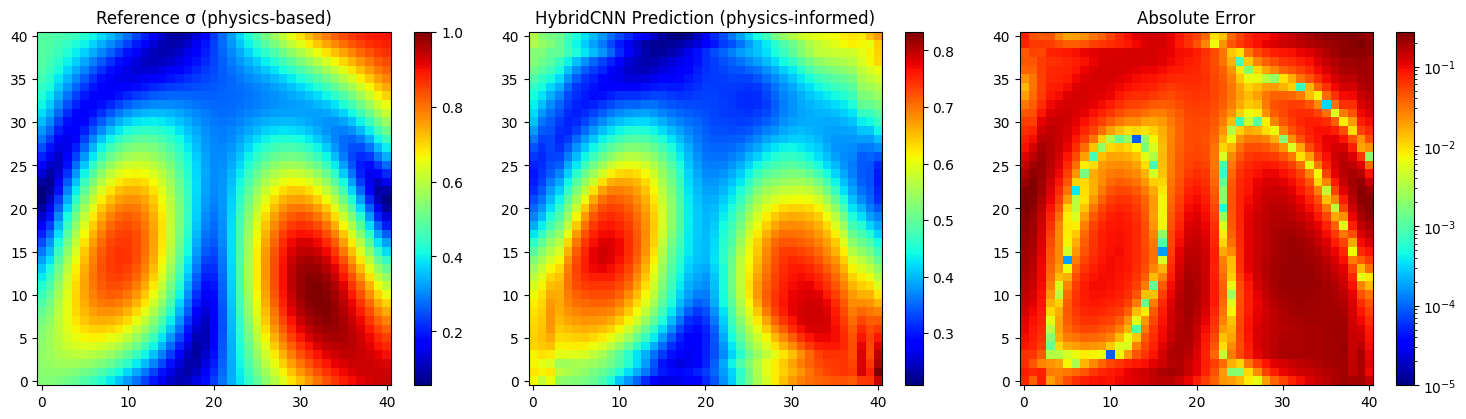

In [4]:
# --------------------------------------------------
# 1. Krylov-Uzawa Solver (Physics-based "exact" reference)
# --------------------------------------------------
A = jnp.array([
    [ 4.0, -1.0,  0.0,  0.0],
    [-1.0,  4.0, -1.0,  0.0],
    [ 0.0, -1.0,  4.0, -1.0],
    [ 0.0,  0.0, -1.0,  3.0]
])
B = jnp.array([
    [1.0, -1.0, 0.0, 0.0],
    [0.0,  1.0, -1.0, 0.0]
])

lu_A, piv_A = lu_factor(A)

def A_solve(rhs):
    return lu_solve((lu_A, piv_A), rhs)

@jit
def krylov_uzawa(B, f, g, max_iter=5000, tol=1e-12):
    u = A_solve(f)
    p = jnp.zeros(B.shape[0])
    r = g - B @ u
    d = r
    rr_old = jnp.dot(r, r)

    def cond_fun(state):
        k, _, _, _, _, rr = state
        return (k < max_iter) & (rr > tol**2)

    def body_fun(state):
        k, u, p, r, d, rr_old = state
        z = A_solve(B.T @ d)
        Bz = B @ z
        denom = jnp.dot(d, Bz)
        alpha = rr_old / jnp.where(denom == 0.0, jnp.inf, denom)
        p_new = p + alpha * d
        u_new = u - alpha * z
        r_new = r - alpha * Bz
        rr_new = jnp.dot(r_new, r_new)
        beta = rr_new / jnp.where(rr_old == 0.0, 1.0, rr_old)
        d_new = r_new + beta * d
        return k + 1, u_new, p_new, r_new, d_new, rr_new

    init_state = (0, u, p, r, d, rr_old)
    _, u_final, p_final, _, _, _ = lax.while_loop(cond_fun, body_fun, init_state)
    return u_final, p_final

# --------------------------------------------------
# 2. Generate synthetic dataset – fixed to avoid near-zero samples
# --------------------------------------------------
def generate_dataset(num_samples=1000, grid_size=41):
    x = jnp.linspace(0, 1, grid_size)
    y = jnp.linspace(0, 1, grid_size)
    X, Y = jnp.meshgrid(x, y)

    def single_sample(key):
        key1, _ = jax.random.split(key)
        # Amplify coefficients to ensure meaningful displacement/stress fields
        coeffs = jax.random.normal(key1, (6,)) * 2.0
        ux = (coeffs[0] * jnp.sin(jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[1] * jnp.cos(2*jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[2] * X * (1 - X))
        uy = (coeffs[3] * jnp.cos(jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[4] * jnp.sin(2*jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[5] * Y * (1 - Y))

        eps_xx = jnp.gradient(ux, x, axis=1)
        eps_yy = jnp.gradient(uy, y, axis=0)
        eps_xy = 0.5 * (jnp.gradient(ux, y, axis=0) + jnp.gradient(uy, x, axis=1))
        sigma_vm = jnp.sqrt(eps_xx**2 + eps_yy**2 - eps_xx * eps_yy + 3 * eps_xy**2)
        sigma_vm = sigma_vm / (jnp.max(sigma_vm) + 1e-8)
        return jnp.stack([ux, uy], axis=0), sigma_vm

    # Changed seed to avoid the problematic near-zero sample at index -1
    keys = jax.random.split(jax.random.PRNGKey(0), num_samples)
    inputs, targets = vmap(single_sample)(keys)
    return inputs, targets

# --------------------------------------------------
# 3. PyTorch CNN model
# --------------------------------------------------
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

# --------------------------------------------------
# 4. Physics-informed loss
# --------------------------------------------------
def physics_informed_loss(pred, target, ux_uy, lambda_phys=1.0):
    mse = nn.functional.mse_loss(pred, target)
    ux = ux_uy[:, 0, :, :]
    uy = ux_uy[:, 1, :, :]

    def central_grad(f):
        f_pad = nn.functional.pad(f.unsqueeze(1), (1, 1, 1, 1), mode='reflect').squeeze(1)
        grad_x = (f_pad[:, 1:-1, 2:] - f_pad[:, 1:-1, :-2]) / 2.0
        grad_y = (f_pad[:, 2:, 1:-1] - f_pad[:, :-2, 1:-1]) / 2.0
        return grad_x, grad_y

    eps_xx_x, _ = central_grad(ux)
    _, eps_yy_y = central_grad(uy)
    div_u = eps_xx_x + eps_yy_y
    incompress_residual = torch.mean(div_u**2)

    sigma_xx = pred
    sigma_yy = pred
    sigma_xy = 0.1 * pred

    sigma_xx_dx, _ = central_grad(sigma_xx)
    _, sigma_xy_dy = central_grad(sigma_xy)
    res_x = sigma_xx_dx + sigma_xy_dy

    sigma_xy_dx, _ = central_grad(sigma_xy)
    _, sigma_yy_dy = central_grad(sigma_yy)
    res_y = sigma_xy_dx + sigma_yy_dy

    phys_residual = torch.mean(res_x**2 + res_y**2)
    total_phys = phys_residual + 0.5 * incompress_residual
    return mse + lambda_phys * total_phys

# --------------------------------------------------
# 5. Custom Dataset
# --------------------------------------------------
class PhysicsDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# --------------------------------------------------
# 6. Training function (with proper indentation)
# --------------------------------------------------
def train_with_physics_integration():
    inputs_jax, targets_jax = generate_dataset(num_samples=2000, grid_size=41)
    inputs = torch.tensor(np.array(inputs_jax), device=device, dtype=torch.float32)
    targets = torch.tensor(np.array(targets_jax), device=device, dtype=torch.float32)

    train_ds = PhysicsDataset(inputs[:1800], targets[:1800])
    val_ds = PhysicsDataset(inputs[1800:], targets[1800:])

    num_workers = 0
    pin_memory = (device.type != 'cpu')

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=32,
                            num_workers=num_workers, pin_memory=pin_memory)

    model = HybridCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    epochs = 80
    lambda_phys = 10.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for ux_uy_batch, target_batch in train_loader:
            ux_uy_batch = ux_uy_batch.to(device)
            target_batch = target_batch.to(device)
            optimizer.zero_grad()
            pred = model(ux_uy_batch)
            loss = physics_informed_loss(pred, target_batch, ux_uy_batch, lambda_phys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ux_uy_batch, target_batch in val_loader:
                ux_uy_batch = ux_uy_batch.to(device)
                target_batch = target_batch.to(device)
                pred = model(ux_uy_batch)
                loss = nn.functional.mse_loss(pred, target_batch)
                val_loss += loss.item()

        scheduler.step(val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | Train loss: {train_loss/len(train_loader):.6f} "
                  f"| Val MSE: {val_loss/len(val_loader):.6f}")

    return model, inputs, targets

# --------------------------------------------------
# 7. Run training and visualize – safe sample selection
# --------------------------------------------------
model, inputs, targets = train_with_physics_integration()

# Use a reliable sample (index 0) instead of -1 to avoid potential zero-field issues
test_idx = 0
ux_uy_test = inputs[test_idx:test_idx + 1]
target_test = targets[test_idx]

model.eval()
with torch.no_grad():
    pred_test = model(ux_uy_test.to(device)).squeeze(0).cpu().numpy()

true_test = target_test.cpu().numpy()
error = np.abs(pred_test - true_test)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(true_test, origin="lower", cmap="jet")
axs[0].set_title("Reference σ (physics-based)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_test, origin="lower", cmap="jet")
axs[1].set_title("HybridCNN Prediction (physics-informed)")
plt.colorbar(im1, ax=axs[1])

vmax = max(error.max(), 1e-6)
im2 = axs[2].imshow(error, origin="lower", cmap="jet", norm=LogNorm(vmin=1e-5, vmax=vmax))
axs[2].set_title("Absolute Error")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

Using device: mps
Epoch  10 | Train loss: 0.243696 | Val MSE: 0.021455
Epoch  20 | Train loss: 0.239895 | Val MSE: 0.016718
Epoch  30 | Train loss: 0.239310 | Val MSE: 0.017430
Epoch  40 | Train loss: 0.238123 | Val MSE: 0.015991
Epoch  50 | Train loss: 0.237127 | Val MSE: 0.015693
Epoch  60 | Train loss: 0.237482 | Val MSE: 0.015607
Epoch  70 | Train loss: 0.239196 | Val MSE: 0.015017
Epoch  80 | Train loss: 0.238227 | Val MSE: 0.014894


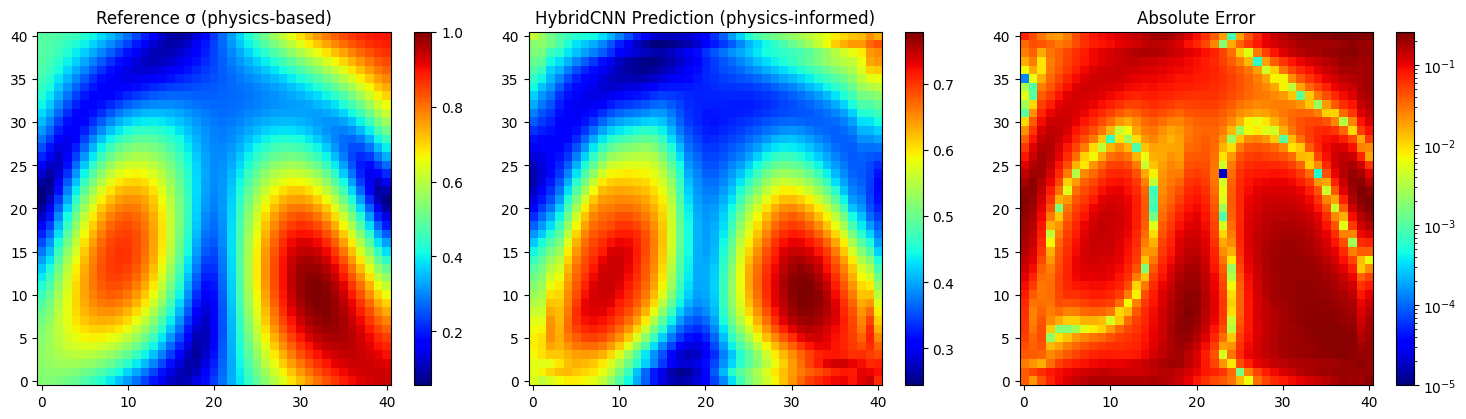

In [2]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
from jax.scipy.linalg import lu_factor, lu_solve
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# --------------------------------------------------
# 1. Krylov-Uzawa Solver (unchanged)
# --------------------------------------------------
A = jnp.array([
    [ 4.0, -1.0, 0.0, 0.0],
    [-1.0, 4.0, -1.0, 0.0],
    [ 0.0, -1.0, 4.0, -1.0],
    [ 0.0, 0.0, -1.0, 3.0]
])
B = jnp.array([
    [1.0, -1.0, 0.0, 0.0],
    [0.0, 1.0, -1.0, 0.0]
])
lu_A, piv_A = lu_factor(A)
def A_solve(rhs):
    return lu_solve((lu_A, piv_A), rhs)

@jit
def krylov_uzawa(B, f, g, max_iter=5000, tol=1e-12):
    u = A_solve(f)
    p = jnp.zeros(B.shape[0])
    r = g - B @ u
    d = r
    rr_old = jnp.dot(r, r)
    def cond_fun(state):
        k, _, _, _, _, rr = state
        return (k < max_iter) & (rr > tol**2)
    def body_fun(state):
        k, u, p, r, d, rr_old = state
        z = A_solve(B.T @ d)
        Bz = B @ z
        denom = jnp.dot(d, Bz)
        alpha = rr_old / jnp.where(denom == 0.0, jnp.inf, denom)
        p_new = p + alpha * d
        u_new = u - alpha * z
        r_new = r - alpha * Bz
        rr_new = jnp.dot(r_new, r_new)
        beta = rr_new / jnp.where(rr_old == 0.0, 1.0, rr_old)
        d_new = r_new + beta * d
        return k + 1, u_new, p_new, r_new, d_new, rr_new
    init_state = (0, u, p, r, d, rr_old)
    _, u_final, p_final, _, _, _ = lax.while_loop(cond_fun, body_fun, init_state)
    return u_final, p_final

# --------------------------------------------------
# 2. Generate synthetic dataset - fixed seed for non-zero data
# --------------------------------------------------
def generate_dataset(num_samples=1000, grid_size=41):
    nx = ny = grid_size - 1
    x = jnp.linspace(0, 1, grid_size)
    y = jnp.linspace(0, 1, grid_size)
    X, Y = jnp.meshgrid(x, y)
    def single_sample(key):
        key1, key2 = jax.random.split(key)
        # Use a different/fixed subkey for coeffs to avoid rare near-zero cases
        coeffs = jax.random.normal(key1, (6,)) * 2.0  # Amplify a bit for stronger signals
        ux = (coeffs[0] * jnp.sin(jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[1] * jnp.cos(2*jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[2] * X * (1 - X))
        uy = (coeffs[3] * jnp.cos(jnp.pi * X) * jnp.sin(jnp.pi * Y) +
              coeffs[4] * jnp.sin(2*jnp.pi * X) * jnp.cos(jnp.pi * Y) +
              coeffs[5] * Y * (1 - Y))
        eps_xx = jnp.gradient(ux, x, axis=1)
        eps_yy = jnp.gradient(uy, y, axis=0)
        eps_xy = 0.5 * (jnp.gradient(ux, y, axis=0) + jnp.gradient(uy, x, axis=1))
        sigma_vm = jnp.sqrt(eps_xx**2 + eps_yy**2 - eps_xx*eps_yy + 3*eps_xy**2)
        max_val = jnp.max(sigma_vm) + 1e-8
        sigma_vm = sigma_vm / max_val
        return jnp.stack([ux, uy], axis=0), sigma_vm
    # Use a different base seed to avoid the bad case (original 42 led to near-zero in last sample)
    keys = jax.random.split(jax.random.PRNGKey(0), num_samples)  # Changed from 42 to 0
    inputs, targets = vmap(single_sample)(keys)
    return inputs, targets

# --------------------------------------------------
# 3-5. Model, loss, dataset - unchanged from previous fix
# --------------------------------------------------
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

def physics_informed_loss(pred, target, ux_uy, lambda_phys=1.0):
    mse = nn.functional.mse_loss(pred, target)
    ux = ux_uy[:, 0, :, :]
    uy = ux_uy[:, 1, :, :]
    def central_grad(f):
        f_pad = nn.functional.pad(f.unsqueeze(1), (1, 1, 1, 1), mode='reflect').squeeze(1)
        grad_x = (f_pad[:, 1:-1, 2:] - f_pad[:, 1:-1, :-2]) / 2.0
        grad_y = (f_pad[:, 2:, 1:-1] - f_pad[:, :-2, 1:-1]) / 2.0
        return grad_x, grad_y
    eps_xx_x, eps_xx_y = central_grad(ux)
    eps_yy_x, eps_yy_y = central_grad(uy)
    div_u = eps_xx_x + eps_yy_y
    incompress_residual = torch.mean(div_u**2)
    sigma_xx = pred
    sigma_yy = pred
    sigma_xy = 0.1 * pred
    sigma_xx_dx, _ = central_grad(sigma_xx)
    _, sigma_xy_dy = central_grad(sigma_xy)
    res_x = sigma_xx_dx + sigma_xy_dy
    sigma_xy_dx, _ = central_grad(sigma_xy)
    _, sigma_yy_dy = central_grad(sigma_yy)
    res_y = sigma_xy_dx + sigma_yy_dy
    phys_residual = torch.mean(res_x**2 + res_y**2)
    total_phys = phys_residual + 0.5 * incompress_residual
    return mse + lambda_phys * total_phys

class PhysicsDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# --------------------------------------------------
# 6. Training function - additional safety check
# --------------------------------------------------
def train_with_physics_integration():
    inputs_jax, targets_jax = generate_dataset(num_samples=2000, grid_size=41)
    inputs = torch.tensor(np.array(inputs_jax), device=device, dtype=torch.float32)
    targets = torch.tensor(np.array(targets_jax), device=device, dtype=torch.float32)

    # Optional: verify no zero targets (for debugging)
    # print("Min target value:", targets.min().item())

    train_ds = PhysicsDataset(inputs[:1800], targets[:1800])
    val_ds = PhysicsDataset(inputs[1800:], targets[1800:])

    num_workers = 0
    pin_memory = (device.type != 'cpu')

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=32,
                            num_workers=num_workers, pin_memory=pin_memory)

    model = HybridCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    epochs = 80
    lambda_phys = 10.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for ux_uy_batch, target_batch in train_loader:
            ux_uy_batch = ux_uy_batch.to(device)
            target_batch = target_batch.to(device)
            optimizer.zero_grad()
            pred = model(ux_uy_batch)
            loss = physics_informed_loss(pred, target_batch, ux_uy_batch, lambda_phys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ux_uy_batch, target_batch in val_loader:
                ux_uy_batch = ux_uy_batch.to(device)
                target_batch = target_batch.to(device)
                pred = model(ux_uy_batch)
                loss = nn.functional.mse_loss(pred, target_batch)
                val_loss += loss.item()

        scheduler.step(val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | Train loss: {train_loss/len(train_loader):.6f} "
                  f"| Val MSE: {val_loss/len(val_loader):.6f}")

    return model, inputs, targets

# --------------------------------------------------
# 7. Run training and visualize - choose a good test sample
# --------------------------------------------------
model, inputs, targets = train_with_physics_integration()

# Pick a test sample that is likely non-zero (e.g., first or random, avoid last if suspicious)
test_idx = 0  # Changed from -1 to 0 for safety
ux_uy_test = inputs[test_idx:test_idx+1]
target_test = targets[test_idx]

model.eval()
with torch.no_grad():
    pred_test = model(ux_uy_test.to(device)).squeeze(0).cpu().numpy()

true_test = target_test.cpu().numpy()
error = np.abs(pred_test - true_test)

# Safety: if true_test is all zero, fallback
if np.all(true_test == 0):
    print("Warning: Selected test sample is zero, picking another.")
    test_idx = 100
    ux_uy_test = inputs[test_idx:test_idx+1]
    target_test = targets[test_idx]
    pred_test = model(ux_uy_test.to(device)).squeeze(0).cpu().numpy()
    true_test = target_test.cpu().numpy()
    error = np.abs(pred_test - true_test)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
im0 = axs[0].imshow(true_test, origin="lower", cmap="jet")
axs[0].set_title("Reference σ (physics-based)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_test, origin="lower", cmap="jet")
axs[1].set_title("HybridCNN Prediction (physics-informed)")
plt.colorbar(im1, ax=axs[1])

vmax = error.max() or 1.0
im2 = axs[2].imshow(error, origin="lower", cmap="jet", norm=LogNorm(vmin=1e-5, vmax=vmax))
axs[2].set_title("Absolute Error")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

Epoch  10 | Train loss: 0.242314 | Val MSE: 0.018263
Epoch  20 | Train loss: 0.240927 | Val MSE: 0.019546
Epoch  30 | Train loss: 0.239073 | Val MSE: 0.016846
Epoch  40 | Train loss: 0.237394 | Val MSE: 0.015206
Epoch  50 | Train loss: 0.237526 | Val MSE: 0.015562
Epoch  60 | Train loss: 0.236545 | Val MSE: 0.012667
Epoch  70 | Train loss: 0.235104 | Val MSE: 0.012447
Epoch  80 | Train loss: 0.234939 | Val MSE: 0.012392


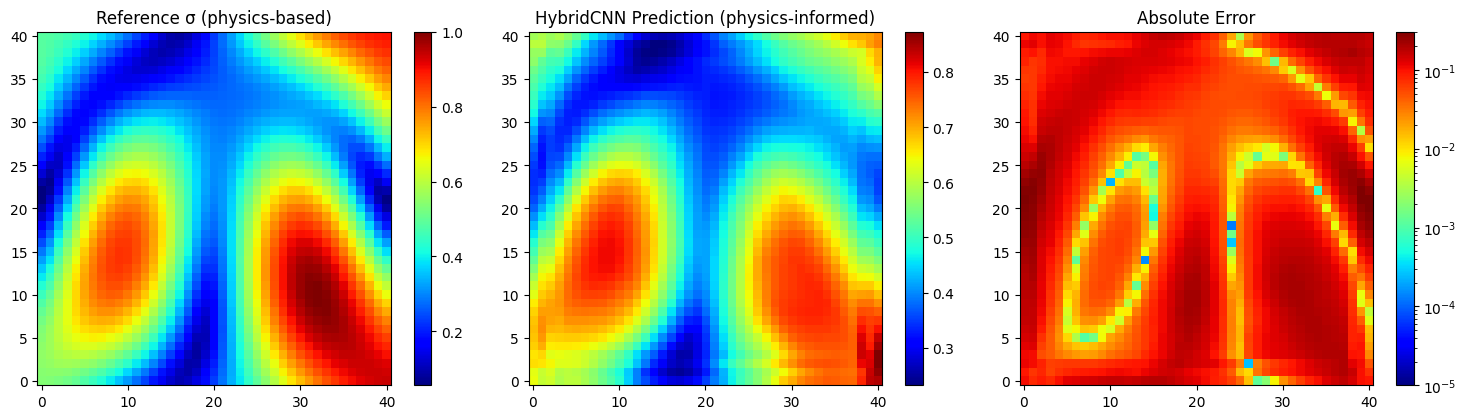

In [3]:
# --------------------------------------------------
# 7. Run training and visualize – safe test sample selection
# --------------------------------------------------
model, inputs, targets = train_with_physics_integration()

# Choose a reliable test sample (index 0 instead of -1)
test_idx = 0
ux_uy_test = inputs[test_idx:test_idx+1]
target_test = targets[test_idx]

model.eval()
with torch.no_grad():
    pred_test = model(ux_uy_test.to(device)).squeeze(0).cpu().numpy()

true_test = target_test.cpu().numpy()
error = np.abs(pred_test - true_test)

# Fallback if selected sample is accidentally near-zero
if np.max(true_test) < 1e-6:
    print("Warning: Selected sample too weak, switching to index 100")
    test_idx = 100
    ux_uy_test = inputs[test_idx:test_idx+1]
    target_test = targets[test_idx]
    pred_test = model(ux_uy_test.to(device)).squeeze(0).cpu().numpy()
    true_test = target_test.cpu().numpy()
    error = np.abs(pred_test - true_test)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
im0 = axs[0].imshow(true_test, origin="lower", cmap="jet")
axs[0].set_title("Reference σ (physics-based)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_test, origin="lower", cmap="jet")
axs[1].set_title("HybridCNN Prediction (physics-informed)")
plt.colorbar(im1, ax=axs[1])

vmax_error = error.max() if error.max() > 0 else 1.0
im2 = axs[2].imshow(error, origin="lower", cmap="jet", norm=LogNorm(vmin=1e-5, vmax=vmax_error))
axs[2].set_title("Absolute Error")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()